**Author:** @curbsideprophet  
**Date written:** 2021-12-20  
**Last updated:** 2022-01-31  
**Objective:** calculate the running differential balance of every Ergo wallet address over time  
**Source:** https://www.lookintobitcoin.com/charts/puell-multiple/  

**Formula:**  
i = Ergo mined * Ergo price  
puell = i / moving_365days_average(i)  

**In the wild:** https://www.reddit.com/r/ergonauts/comments/rhx3ko/ergo_puell_multiple_courtesy_of_ergostats/

## Load modules

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from coingecko_fetch import *

from sqlalchemy import create_engine

## Grab daily price data

In [2]:
ergo = coingecko_fetch("ergo")
ergo['timestamp'] = pd.to_datetime(ergo['timestamp'])
ergo['date'] = ergo['timestamp']

## Retrieve on-chain data

In [3]:
POSTGRES_ADDRESS = ADDRESS
POSTGRES_PORT = PORT
POSTGRES_USERNAME = USERNAME
POSTGRES_PASSWORD = PASSWORD
POSTGRES_DBNAME = DBNAME

postgres_str = ('postgresql://{username}:{password}@{ipaddress}:{port}/{dbname}'.format(username=POSTGRES_USERNAME,password=POSTGRES_PASSWORD,ipaddress=POSTGRES_ADDRESS,port=POSTGRES_PORT,dbname=POSTGRES_DBNAME))

conn = create_engine(postgres_str)

qry = open('../sql/ergo-miner_revenue.sql', 'r')
circ = pd.read_sql_query(qry.read(), conn)
qry.close()

## Calculate Ergo issuance per day

In [4]:
circ = circ[['date', 'miner_revenue']]
circ['date'] = pd.to_datetime(circ['date'])
circ = circ.merge(ergo, on='date')
circ['issuance'] = circ['miner_revenue'] * circ['price']
circ['yoy'] = circ['issuance'].rolling(window=365).mean()
circ['puell'] = circ['issuance'] / circ['yoy']

# Join final data frame
## Filter out data when 365 day historical value begins
circ_clean = circ[circ['date'] >= '2020-05-01']

## Plot data

<Figure size 432x288 with 0 Axes>

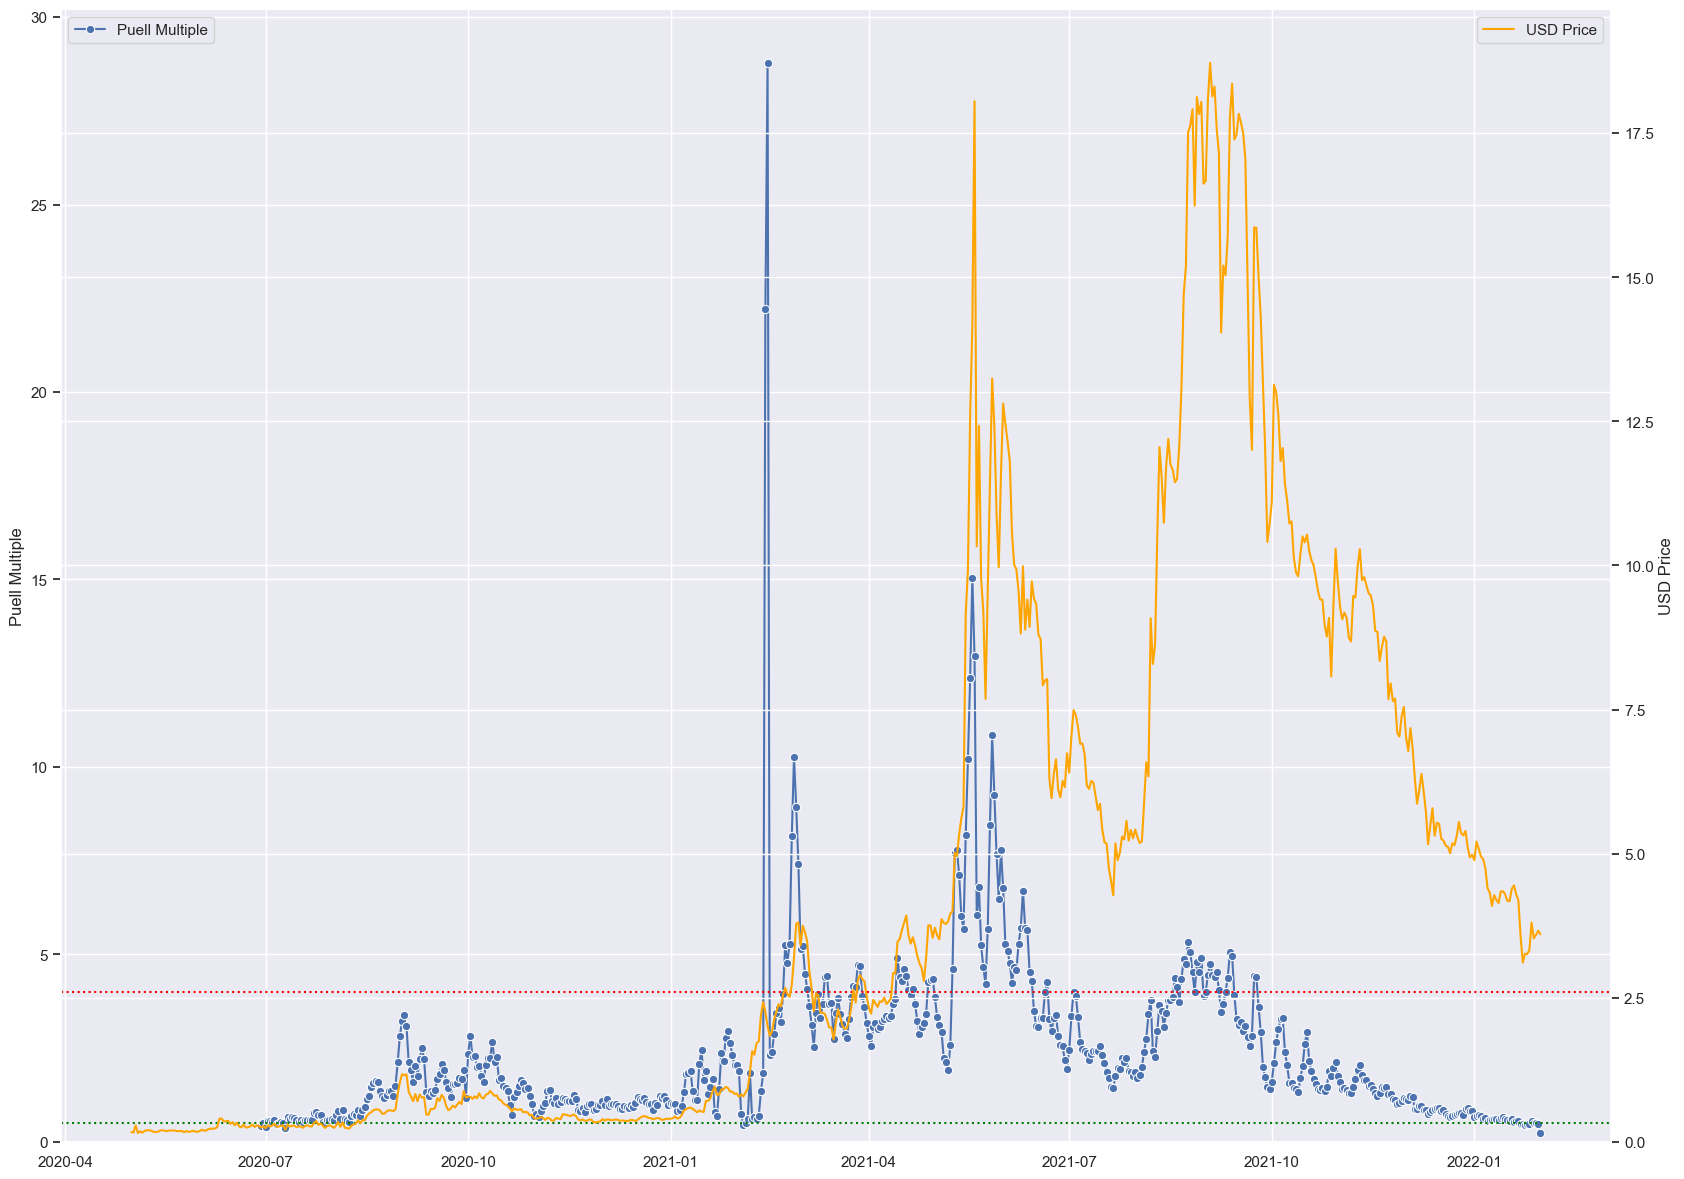

In [5]:
sns.set(style='darkgrid')

plt.clf()
plt.rcParams["figure.dpi"] = 100
fig, ax = plt.subplots(figsize=(20,15))

sns.lineplot(x='date', y='puell', data=circ_clean, marker='o', label='Puell Multiple')
plt.axhline(y=4.00, color='red', linestyle=':')
plt.axhline(y=0.50, color='green', linestyle=':')

ax2 = plt.twinx()
sns.lineplot(x='date', y='price', data=circ_clean, ax=ax2, color='orange', label='USD Price')

ax.set_ylim(0)
ax.set_xlabel("")
ax.set_ylabel("Puell Multiple")
ax2.set_ylim(0)
ax2.set_ylabel("USD Price")

ax.legend(loc=2)
ax2.legend(loc=0)

plt.show()